In [31]:
from time import sleep
import json
import requests
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
landuses = gpd.read_parquet('/app/data/landuses_actual.parquet')

In [33]:
landuses['Uso'].unique()

array(['SITIO ERIAZO', 'BIENES COMUNES', 'OTROS', 'SALUD', 'CULTO',
       'BODEGA Y ALMACENAJE', 'HABITACIONAL', 'OFICINA', 'COMERCIO',
       'EDUCACION Y CULTURA', 'INDUSTRIA', 'AREAS VERDES', 'PRE ROL',
       'TRANSPORTE Y TELEC', 'DEPORTE Y RECREACION', 'HOTEL, MOTEL',
       'ESTACIONAMIENTO', 'ADM PUBLICA Y DEFENSA', 'MULTI ROL',
       'AGRICOLA'], dtype=object)

In [42]:
NAICS = {
}

LBCS = {
    'SITIO ERIAZO': 9000,
    'BIENES COMUNES': 9999,
    'OTROS': 9200,
    'SALUD': 6500,
    'CULTO': 6600,
    'BODEGA Y ALMACENAJE': 3120,
    'HABITACIONAL': 1100,
    'OFICINA': 2300,
    'COMERCIO': 2100,
    'EDUCACION Y CULTURA': 4100,
    'INDUSTRIA': 3000,
    'AREAS VERDES': 7000,
    'PRE ROL': 9999,
    'TRANSPORTE Y TELEC': 4000, #4340 Telecomunicaciones
    'DEPORTE Y RECREACION': 7100,
    'HOTEL, MOTEL': 1200,
    'ESTACIONAMIENTO': 5210,
    'ADM PUBLICA Y DEFENSA': 6200, #+6300
    'MULTI ROL': 9999,
    'AGRICOLA': 9000,
}

LBCS_translated = {
    'SITIO ERIAZO': 'Vacant lot',
    'BIENES COMUNES': 'Public spaces',
    'OTROS': 'Other',
    'SALUD': 'Healthcare',
    'CULTO': 'Religious',
    'BODEGA Y ALMACENAJE': 'Warehouse and storage',
    'HABITACIONAL': 'Residential',
    'OFICINA': 'Office',
    'COMERCIO': 'Commercial',
    'EDUCACION Y CULTURA': 'Education and culture',
    'INDUSTRIA': 'Industry',
    'AREAS VERDES': 'Park',
    'TRANSPORTE Y TELEC': 'Transportation and telecommunications', #4340 Telecommunications
    'DEPORTE Y RECREACION': 'Sports and recreation',
    'HOTEL, MOTEL': 'Hotel, motel',
    'ESTACIONAMIENTO': 'Parking',
    'ADM PUBLICA Y DEFENSA': 'Public administration and defense', #+6300
    'AGRICOLA': 'Agricultural',
}



In [43]:
grid = gpd.read_parquet('/app/data/geogrid.parquet')

In [55]:
grid.set_crs(4326, inplace=True)

,geometry,color,height,name,interactive,id
0,"POLYGON ((-73.07591 -36.82542, -73.07550 -36.8...","[126, 179, 70]","[0, 0, 0]",Park,True,0
1,"POLYGON ((-73.07512 -36.82509, -73.07471 -36.8...","[126, 179, 70]","[0, 0, 0]",Park,True,1
2,"POLYGON ((-73.07433 -36.82476, -73.07393 -36.8...","[171, 143, 57]","[0, 15, 30]",Campus,False,2
3,"POLYGON ((-73.07355 -36.82444, -73.07314 -36.8...","[185, 126, 24]","[0, 50, 100]",Residential,True,3
4,"POLYGON ((-73.07276 -36.82411, -73.07235 -36.8...","[185, 126, 24]","[0, 50, 100]",Residential,True,4
...,...,...,...,...,...,...
520,"POLYGON ((-73.05423 -36.84365, -73.05382 -36.8...","[126, 179, 70]","[0, 0, 0]",Park,True,520
521,"POLYGON ((-73.05344 -36.84333, -73.05303 -36.8...","[171, 143, 57]","[0, 15, 30]",Campus,False,521
522,"POLYGON ((-73.05265 -36.84300, -73.05225 -36.8...","[171, 143, 57]","[0, 15, 30]",Campus,False,522
523,"POLYGON ((-73.05187 -36.84267, -73.05146 -36.8...","[36, 130, 198]","[0, 50, 100]",Office,True,523


In [45]:
landuses['LBCS'] = landuses['Uso'].map(LBCS_translated)

In [46]:
landuses.dropna(subset=['LBCS'], inplace=True)

In [47]:
landuses.to_crs(4326, inplace=True)

In [40]:
from shapely.geometry import Polygon, MultiPolygon

def remove_z(geometry):
    if geometry.is_empty:
        return geometry
    if isinstance(geometry, Polygon):
        # Crear una nueva geometría Polygon sin la componente Z
        exterior_coords = [(x, y) for x, y, z in geometry.exterior.coords]
        new_exterior = Polygon(exterior_coords)
        
        # Procesar los interiores (agujeros)
        new_interiors = []
        for interior in geometry.interiors:
            interior_coords = [(x, y) for x, y, z in interior.coords]
            new_interiors.append(Polygon(interior_coords))
        
        return Polygon(new_exterior.exterior.coords, [interior.exterior.coords for interior in new_interiors])
    elif isinstance(geometry, MultiPolygon):
        # Aplicar la función recursivamente a cada polígono en MultiPolygon
        return MultiPolygon([remove_z(poly) for poly in geometry])
    else:
        # En caso de que la geometría no sea Polygon o MultiPolygon, devolverla sin cambios
        return geometry

# Cargar tu GeoDataFrame (asegúrate de reemplazar 'tu_archivo.shp' con el nombre de tu archivo)
# landuses = gpd.read_file('tu_archivo.shp')

# Aplicar la función remove_z a cada geometría en el GeoDataFrame
landuses['geometry'] = landuses['geometry'].apply(remove_z)

In [48]:
landuses

,Id,Uso,area_predio,plate_id,geometry,LBCS
0,1,SITIO ERIAZO,27346.344287,0.0,"POLYGON ((-73.07318 -36.82560, -73.07391 -36.8...",Vacant lot
1,2,SITIO ERIAZO,10492.919632,0.0,"POLYGON ((-73.06750 -36.82260, -73.06746 -36.8...",Vacant lot
2,3,BIENES COMUNES,2466.609968,0.0,"POLYGON ((-73.07173 -36.82608, -73.07173 -36.8...",Public spaces
3,4,BIENES COMUNES,2107.678619,0.0,"POLYGON ((-73.07190 -36.82598, -73.07192 -36.8...",Public spaces
4,5,BIENES COMUNES,756.003752,0.0,"POLYGON ((-73.07090 -36.82481, -73.07055 -36.8...",Public spaces
...,...,...,...,...,...,...
3058,3963,BIENES COMUNES,808.457116,0.0,"POLYGON ((-73.05725 -36.82732, -73.05748 -36.8...",Public spaces
3079,4044,BIENES COMUNES,681.054330,0.0,"POLYGON ((-73.05526 -36.83209, -73.05514 -36.8...",Public spaces
3082,4049,COMERCIO,2069.054575,0.0,"POLYGON ((-73.05755 -36.83301, -73.05740 -36.8...",Commercial
3084,4053,HABITACIONAL,250.880838,0.0,"POLYGON ((-73.05626 -36.83275, -73.05640 -36.8...",Residential


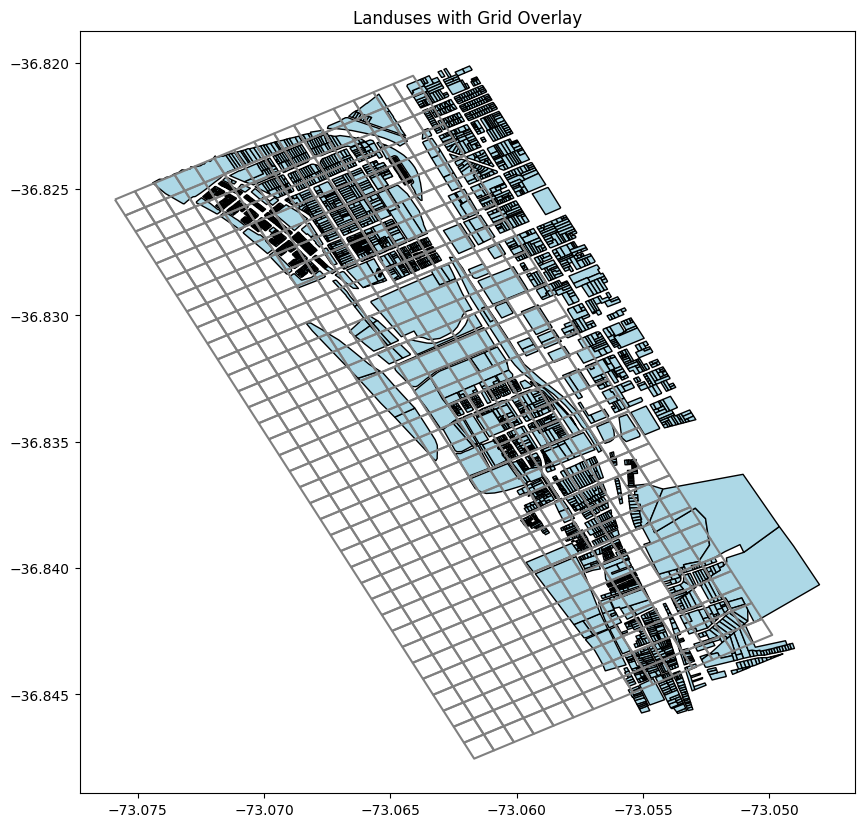

In [50]:
import matplotlib.pyplot as plt

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 10))

# Plotear landuses con un color de relleno y bordes
landuses.plot(ax=ax, color='lightblue', edgecolor='black')

# Plotear grid solo con los bordes de los polígonos en color gris y sin relleno
grid.boundary.plot(ax=ax, edgecolor='grey')

# Configurar el título y mostrar el gráfico
ax.set_title('Landuses with Grid Overlay')
plt.show()

In [56]:
gpd.overlay(landuses, grid)

,Id,Uso,area_predio,plate_id,LBCS,color,height,name,interactive,id,geometry
0,1,SITIO ERIAZO,27346.344287,0.0,Vacant lot,"[126, 179, 70]","[0, 0, 0]",Park,True,1,"POLYGON ((-73.07439 -36.82478, -73.07433 -36.8..."
1,1,SITIO ERIAZO,27346.344287,0.0,Vacant lot,"[171, 143, 57]","[0, 15, 30]",Campus,False,2,"POLYGON ((-73.07391 -36.82518, -73.07425 -36.8..."
2,1,SITIO ERIAZO,27346.344287,0.0,Vacant lot,"[185, 126, 24]","[0, 50, 100]",Residential,True,3,"POLYGON ((-73.07292 -36.82420, -73.07292 -36.8..."
3,1,SITIO ERIAZO,27346.344287,0.0,Vacant lot,"[185, 126, 24]","[0, 50, 100]",Residential,True,4,"POLYGON ((-73.07266 -36.82411, -73.07251 -36.8..."
4,1,SITIO ERIAZO,27346.344287,0.0,Vacant lot,"[185, 126, 24]","[0, 50, 100]",Residential,True,5,"POLYGON ((-73.07186 -36.82375, -73.07183 -36.8..."
...,...,...,...,...,...,...,...,...,...,...,...
3710,3859,INDUSTRIA,7544.394781,0.0,Industry,"[185, 126, 24]","[0, 50, 100]",Residential,True,132,"POLYGON ((-73.06290 -36.82664, -73.06232 -36.8..."
3711,3889,SITIO ERIAZO,1037.748834,0.0,Vacant lot,"[36, 130, 198]","[0, 50, 100]",Office,True,298,"POLYGON ((-73.05757 -36.83348, -73.05748 -36.8..."
3712,4049,COMERCIO,2069.054575,0.0,Commercial,"[36, 130, 198]","[0, 50, 100]",Office,True,298,"POLYGON ((-73.05740 -36.83323, -73.05756 -36.8..."
3713,3912,COMERCIO,5316.434525,0.0,Commercial,"[36, 130, 198]","[0, 50, 100]",Office,True,344,"POLYGON ((-73.05567 -36.83500, -73.05584 -36.8..."
